In [137]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [138]:
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from scipy import stats
import matplotlib.pyplot as plt
import keras.backend as K
import matplotlib.dates as mdates
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from kneed import KneeLocator
%matplotlib inline

In [139]:
root = '/content/drive/MyDrive/Reaps_Final_Submission/'

In [140]:
df = pd.read_csv(root + 'ranchi.csv')
# Randomly select 45% of the rows
df = df.sample(frac=0.04, random_state=82)

In [141]:
df.columns

Index(['PRECTOTCORR', 'RH2M', 'PS', 'WS2M', 'T2M', 'Datetime'], dtype='object')

In [142]:
df.describe()

,PRECTOTCORR,RH2M,PS,WS2M,T2M
count,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000
mean,0.157581,63.398130,94.017254,1.711511,23.296973
std,0.466486,26.711551,0.561382,15.474412,7.227017
min,0.000000,5.500000,92.260000,-999.000000,2.330000
25%,0.000000,42.120000,93.560000,1.080000,18.820000
50%,0.000000,68.120000,94.050000,1.590000,23.940000
75%,0.080000,87.500000,94.500000,2.630000,27.500000
max,11.180000,100.000000,95.230000,10.170000,42.860000


In [143]:
# Select the features for clustering
X = df[['PRECTOTCORR', 'RH2M', 'PS', 'WS2M', 'T2M']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


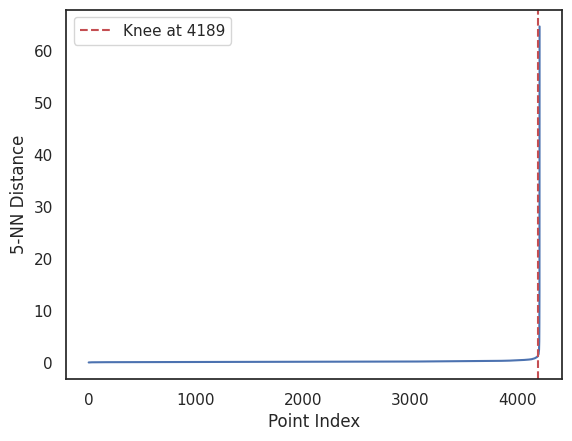

eps = 1.1781050951031282


In [144]:
from sklearn.neighbors import NearestNeighbors
# Select the variables for the analysis
variables = ['PRECTOTCORR', 'RH2M', 'PS', 'WS2M', 'T2M']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[variables])

# Calculate the KNN distances
k = 5
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_scaled)
distances, indices = neigh.kneighbors(X_scaled)

# Find the knee and plot the line
knee = KneeLocator(np.arange(len(distances)), np.sort(distances[:,k-1]), S=1, curve='convex', direction='increasing')
plt.plot(np.arange(len(distances)), np.sort(distances[:,k-1]))
plt.axvline(knee.knee, linestyle='--', color='r', label=f'Knee at {knee.knee}')
plt.legend()
plt.xlabel('Point Index')
plt.ylabel(f'{k}-NN Distance')
plt.show()

# Determine the eps for DBSCAN
eps = np.sort(distances[:,k-1])[int(knee.knee)]
print(f"eps = {eps}")

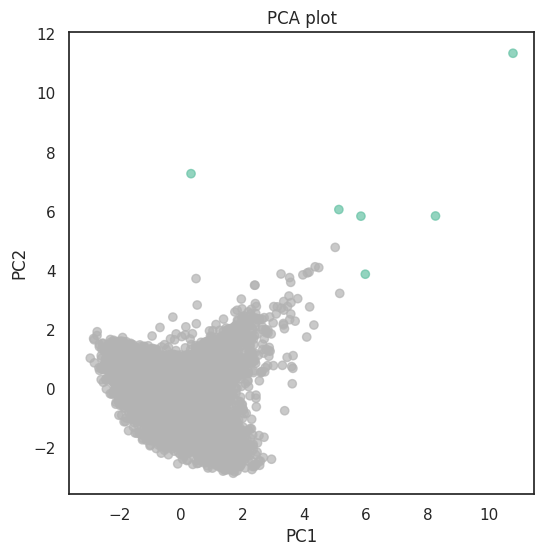

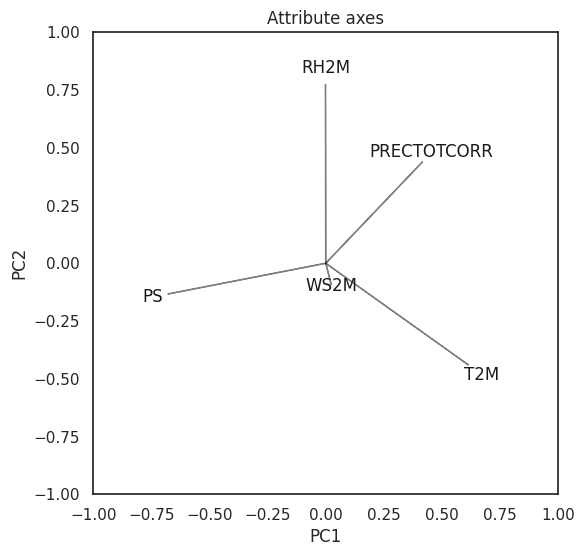

In [152]:
import matplotlib.pyplot as plt

# Perform PCA and select the principal components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Perform DBSCAN clustering on the principal components
dbscan = DBSCAN(eps=eps, min_samples=5)
labels = dbscan.fit_predict(principal_components)

# Create a pandas DataFrame to hold the PCA results
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

# Add a column to the DataFrame to indicate the cluster labels
pca_df['Cluster'] = labels

# Create a figure for the PCA plot
fig1, ax1 = plt.subplots(figsize=(6, 6))
# Plot the PCA results with cluster labels
ax1.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='Set2', alpha=0.7)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PCA plot')

# Create a figure for the attribute axes plot
fig2, ax2 = plt.subplots(figsize=(6, 6))
# Plot the attribute axes
attribute_axes = pca.components_.T
for i, (x, y) in enumerate(attribute_axes):
    ax2.arrow(0, 0, x, y, color='k', alpha=0.5)
    ax2.text(x*1.1, y*1.1, df.columns[i], color='k', ha='center', va='center')
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('Attribute axes')

plt.show()

In [146]:
# Get the component loadings and explained variance ratios
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=df.columns[:-1])
explained_variance_ratios = pd.Series(pca.explained_variance_ratio_, index=['PC1', 'PC2'])

# Print the component loadings and explained variance ratios
print('Component loadings:')
print(loadings)
print('\nExplained variance ratios:')
print(explained_variance_ratios)
print()

# Find the variable with the highest loading for each principal component
for i, pc in enumerate(pca.components_):
    print(f'PC{i+1} - {df.columns[np.argmax(np.abs(pc))]} is the most important variable.')

# Print the loadings and variance ratios
loadings_df = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=df.columns[:-1])
variance_df = pd.DataFrame({'variance_ratio': pca.explained_variance_ratio_,
                            'cumulative_variance_ratio': np.cumsum(pca.explained_variance_ratio_)},
                            index=['PC1', 'PC2'])

print('Loadings:')
print(loadings_df)
print('\nVariance Ratios:')
print(variance_df)

Component loadings:
                  PC1       PC2
PRECTOTCORR  0.413659  0.436418
RH2M        -0.001109  0.769666
PS          -0.675375 -0.132425
WS2M         0.023033 -0.089596
T2M          0.610100 -0.437710

Explained variance ratios:
PC1    0.34799
PC2    0.28100
dtype: float64

PC1 - PS is the most important variable.
PC2 - RH2M is the most important variable.
Loadings:
                  PC1       PC2
PRECTOTCORR  0.413659  0.436418
RH2M        -0.001109  0.769666
PS          -0.675375 -0.132425
WS2M         0.023033 -0.089596
T2M          0.610100 -0.437710

Variance Ratios:
     variance_ratio  cumulative_variance_ratio
PC1         0.34799                    0.34799
PC2         0.28100                    0.62899


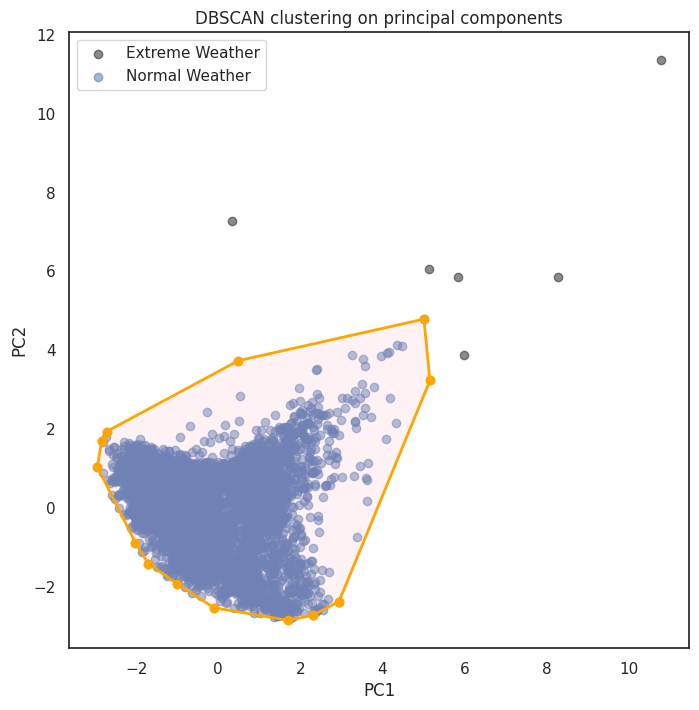

In [147]:
# Get the points of the cluster
cluster_points = principal_components[labels==0]

# Get the convex hull of the cluster points
hull = ConvexHull(cluster_points)

# Plot the DBSCAN results
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(principal_components[labels==-1,0], principal_components[labels==-1,1], c='k', alpha=0.5, label='Extreme Weather')
ax.scatter(principal_components[labels==0,0], principal_components[labels==0,1], c='b', alpha=0.5, label='Normal Weather')
ax.plot(cluster_points[hull.vertices,0], cluster_points[hull.vertices,1], 'o-', lw=2, c='orange')
ax.fill(cluster_points[hull.vertices,0], cluster_points[hull.vertices,1], alpha=0.2, c='pink')
# Add a line from the first to last point of the convex hull
first_point = cluster_points[hull.vertices[0]]
last_point = cluster_points[hull.vertices[-1]]
ax.plot([first_point[0], last_point[0]], [first_point[1], last_point[1]], 'o-', lw=2, c='orange')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('DBSCAN clustering on principal components')
ax.legend()
plt.show()